In [9]:
%pylab inline
from pygadgetreader import *
from octopus import density

Populating the interactive namespace from numpy and matplotlib


In [16]:
disk_pos = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'pos', 'disk')
disk_vel = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'vel', 'disk')
disk_mass = readsnap('../data/LMCMW/MWmLMC6/H1/MWfLMC6H1_119.hdf5', 'mass', 'disk')

Returning DISK  Positions
Returning DISK  Velocities
Returning DISK  Mass


In [24]:
disk_cut = np.where((np.abs(disk_pos[:,0])<50) & ((np.abs(disk_pos[:,1])<100)) & ((np.abs(disk_pos[:,2])<30)))[0]

In [25]:
X_d = disk_pos[disk_cut,0]
Y_d = disk_pos[disk_cut,1]
Z_d = disk_pos[disk_cut,2]

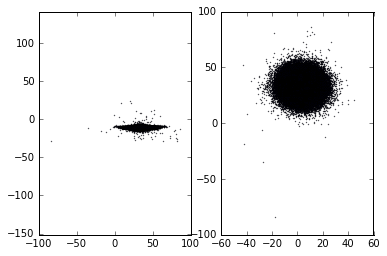

In [37]:
subplot(1, 2, 1)
scatter(Y_d, Z_d, s=0.1)
axis('equal')

subplot(1, 2, 2)
scatter(X_d, Y_d, s=0.1)

#xlim(-30, 30)
#ylim(-20, 0)

In [30]:
disk_dens = density.grid(X_d, Y_d, Z_d, 50)

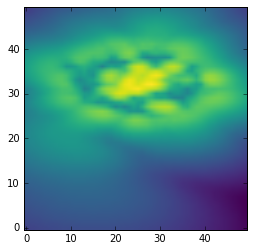

In [48]:
imshow(np.log10(disk_dens.T), origin='lower', cmap='viridis')

In [49]:
disk_densYZ = density.grid(Y_d, Z_d, X_d, 100)

(20, 50)

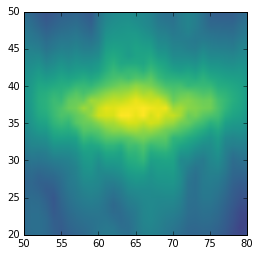

In [61]:

imshow(np.log10(disk_densYZ.T), origin='lower', cmap='viridis')
xlim(50, 80)
ylim(20, 50)